# Logistic regression with Python

In this machine problem (MP), you will implement a simple logistic regression model in Python. You will load MNIST dataset and visualize the results using Matplotlib.

In [1]:
import math
import torch
import random
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'
%matplotlib inline


def reset_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

reset_seed(42)

## In-class implementation: 2-class logistic regression on MNIST

**Task1: Download MNIST dataset**

Write a Python function named `download_mnist` that downloads MNIST dataset using `torchvision.datasets`. You can refer to the document [here](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html?highlight=mnist#torchvision.datasets.MNIST).

Inside the function:
1. Download MNIST dataset using `torchvision.datasets`.

Return:
1. `train_dataset_`: a dataset object that contain raw MNIST images and the labels in train set.
2. `test_dataset_`: a dataset object that contain raw MNIST images and the labels in test set.

In [2]:
def download_mnist():
    ######################################
    ## TODO:  load mnist dataset with   ##
    ## torchvision datasets             ##
    ######################################

    train_dataset_ = datasets.MNIST('MNIST', train=True, download=True)
    test_dataset_ = datasets.MNIST('MNIST', train=False, download=True)

    ######################################
    ############ End of your code ########
    ######################################

    return train_dataset_, test_dataset_

train_dataset_, test_dataset_ = download_mnist()
print(f"First data point in the training set: {train_dataset_[0]}")
# Convert image to numpy array
img = np.array(train_dataset_[0][0]).astype(np.float32)
print(f"Image shape: {img.shape}")
print(f"Pixel value range: {img.min()} - {img.max()}")

100%|██████████| 9912422/9912422 [00:00<00:00, 21040989.24it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 88291322.03it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26829802.64it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14007741.74it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



First data point in the training set: (<PIL.Image.Image image mode=L size=28x28 at 0x79E72AFD1FC0>, 5)
Image shape: (28, 28)
Pixel value range: 0.0 - 255.0


To help you undertsand what is contained in the dataset object, we provide you a visualization function to plot the images. You can run the code below to better understand MNIST dataset.

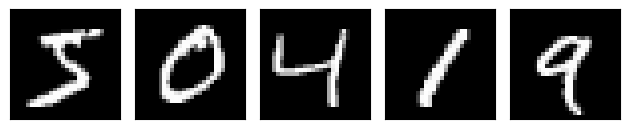

In [3]:
def plot(imgs, row_title=None):
    # This helper function is modified based on https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), cmap='gray')
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

plot([train_dataset_[i][0] for i in range(5)])

**Task2: Preprocess MNIST Dataset**

Write the preprocess function for MNIST dataset. You need to:
1. Write a helper function `normalize_image` that converts an image object into numpy array and then normalize it. To normalize an image, you need to convert the value into the range [0, 1], substract the mean of pixel value, and divide by the standard deviation of pixel value.
2. Write a helper function `transform_mnist` that traverse through the raw dataset, normalize the image (using `normalize_image`), and stack all images into an array.

In [4]:
def normalize_image(image, mean=0.1307, std=0.3081):
    """
    This function normalizes the input Grayscale image into a numpy array.

    Return:
    normalized_image: array of shape (1, height, width), the pixel value is first
    converted to [0, 1] and then normalized with specified mean and std.
    """
    normalized_image = None

    ######################################
    ## TODO: Normalize input image with ##
    ##      specified mean and std      ##
    ######################################

    normalized_image = np.array(image).astype(np.float32)
    normalized_image = normalized_image / 255
    normalized_image = (normalized_image - mean) / std
    normalized_image = normalized_image[None, :, :]

    ######################################
    ############ End of your code ########
    ######################################

    return normalized_image


def transform_mnist(dataset):
    """
    This function transforms all images and stacks them in an array.

    Return:
    features: numpy array of shape (N, 1, height, width)
    targets: numpy array of shape (N, 1)
    where N is the number of data points in the dataset
    """
    features = []
    targets = []

    ############################################
    ## TODO: Transform raw dataset into numpy ##
    ## array dataset                          ##
    ############################################

    for sample in dataset:
        image, label = sample
        features.append(normalize_image(image))
        targets.append(label)

    features = np.stack(features)
    targets = np.stack(targets)[:, None]

    ###########################################
    ############ End of your code #############
    ###########################################

    return features, targets

In [5]:
train_data = transform_mnist(train_dataset_)
test_data = transform_mnist(test_dataset_)
print(train_data[0].shape) # the shape should be (60000, 1, 28, 28)
print(train_data[1].shape) # the shape should be (60000, 1)

(60000, 1, 28, 28)
(60000, 1)


**Task2: Create subset of MNIST**

We will start with a binary classification task, i.e., classifying two digits in the dataset. Write a function `create_2class_subset` for MNIST dataset that extracts the data for `pos_class` and `neg_class`, where `pos_class` and `neg_class` are indices of positive and negative classes.

In [6]:
def create_2class_subset(data, pos_class, neg_class):
    """
    This function extracts the samples of label `pos_class` and `neg_class` from full dataset.
    And change the label for pos_class data points to 1, and neg_class data points to -1.

    Return:
    subdata_features: array of shape (N, 1, height, width)
    subdata_targets: array of shape (N, 1)
    where N is the number of data points with label pos_class and neg_class in the dataset
    NOTICE: subdata_targets only contain 1 and -1.
    """
    subdata_features = None
    subdata_targets = None

    ############################################
    ## TODO: Extract the samples of pos_class ##
    ## and neg_class from full data           ##
    ############################################

    data_features, data_targets = data
    index = (data_targets == pos_class) | (data_targets == neg_class)
    subdata_features = data_features[index]
    subdata_targets = data_targets[index]

    index = (subdata_targets == pos_class)
    subdata_targets[index] = 1
    index = (subdata_targets == neg_class)
    subdata_targets[index] = -1

    ###########################################
    ############ End of your code #############
    ###########################################

    return (subdata_features, subdata_targets)

In [7]:
# We will use 1 as positive class and 5 as negative class
pos_class = 1
neg_class = 5
train_features, train_targets = create_2class_subset(train_data, pos_class, neg_class)
test_features, test_targets = create_2class_subset(test_data, pos_class, neg_class)

print(np.unique(test_targets)) # should contain only 1 and -1

[-1  1]


**Task3: Data-helper function for training**

In the previous cells, we have implemented basic data loding functions for MNIST classification. However, we still need several helper functions in training. In this task, you need to implement:
1. A function `get_raw_feature` that converts 2d image into 1d array and uses raw pixel values as features, i.e., flatten the image into a feature vector.
2. A function `random_shuffle` that randomly shuffle the training data.

In [8]:
def raw_feature_func(features):
  raw_features = None
  ############################################
  ## TODO: Reshape the array to obtain      ##
  ## raw feature                            ##
  ############################################

  raw_features = np.reshape(features, (features.shape[0], -1))

  ###########################################
  ############ End of your code #############
  ###########################################

  return raw_features

def random_shuffle(features, targets):
  shuffled_features = None
  shuffled_targets = None
  ############################################
  ## TODO: shuffle the training dataset     ##
  ############################################

  perm = np.random.permutation(features.shape[0])
  shuffled_features = features[perm]
  shuffled_targets = targets[perm]
  shuffled_targets = shuffled_targets[:, None]

  ###########################################
  ############ End of your code #############
  ###########################################
  return (shuffled_features, shuffled_targets)

In [9]:
reset_seed(42) #! DO NOT CHANGE THIS SEED

train_features = raw_feature_func(train_features) # (num_example, 784)
test_features = raw_feature_func(test_features) # (num_example, 784)

train_features, train_targets = random_shuffle(train_features, train_targets)

In [10]:
# test_targets.shape
print(f"Train features shape: {train_features.shape}")
print(f"Train targets shape: {train_targets.shape}")

Train features shape: (12163, 784)
Train targets shape: (12163, 1)


**Task4: Gradient Descent Training**

Now, we have all data-related functions ready. In this task, you need to implement the Gradient Descent algorithm for 2-class MNIST classification. You need to implement:
1. A function `weight_initialization` that initializes the model parameters using `np.random.randn` function.
2. A function `calc_grad` that calculates the gradient with respect to model's parameters given input features and targets.
3. A function `train_gradient_descent`, that impelements the gradient descent algorithm and visualize the training loss and accuracy across the training steps.
4. A function `visualize_loss_acc`, that visualizes the training loss and accuracy using matplotlib.
5. Evaluate the trained model on the test set and report the test accuracdy.

In [11]:
from torchvision.datasets.utils import calculate_md5
def weight_initialization(shape):
  '''
  This function initializes the model's weight.

  Input:
  shape: the shape of the parameter

  Return:
  w: the paramter of the logistic regression model.
  '''
  w = np.array(0)
  ############################################
  ## TODO: initialize the weight using      ##
  ## np.random.randn                        ##
  ############################################

  w = np.random.randn(*shape)

  ###########################################
  ############ End of your code #############
  ###########################################
  return w

def calc_grad(w, features, targets):
  '''
  This function computes the gradient given w, X, and y.
  w is (784, 1), X is (12163, 784), targets is (12163, 1)

  Return:
  grad: the gradient.
  '''
  grad = np.zeros([features.shape[1], 1])
  ############################################
  ## TODO: calculate the gradient of w      ##
  ## for the samples (features, targets).   ##
  ############################################

  for i in range(features.shape[0]):
    x = features[i]
    y = targets[i]
    g = (-1 * y * x) / (1 + np.e ** (y * x @ w))
    g = g[:, np.newaxis]
    grad += g

  # grad = grad / features.shape[0]


  ###########################################
  ############ End of your code #############
  ###########################################
  return grad

def visualize_loss_acc(losses, accs):
  '''
  This function plots the loss curve and accuracy curve using matplotlib.
  '''
  # use matplotlib plot train curves
  fig, axs = plt.subplots(1, 2, figsize=(12, 5))
  axs = axs.flatten()

  ############################################
  ## TODO: Plot the train curves            ##
  ############################################

  axs[0].plot(losses)
  axs[0].set_title(f"Loss")
  axs[1].plot(accs)
  axs[1].set_title(f"Accuracy")

  ###########################################
  ############ End of your code #############
  ###########################################

  # Show the figure.
  plt.show()

def train_gradient_descent(num_epochs, lr, w, train_features, train_targets):
  '''
  This function trains the model w using gradient desent on the dataset (train_features, train_targets).

  Returns:
  w_star: the optimized model parameter w.
  '''
  losses = []
  accs = []
  N = train_features.shape[0]

  # Train loop
  for i in range(num_epochs):

    grad = np.zeros_like(w)

    ############################################
    ## TODO: calculate the gradient for w.    ##
    ## And then update w                      ##
    ############################################

    grad = calc_grad(w, train_features, train_targets)
    w += -1 * lr * grad
    # print(w)

    ###########################################
    ############ End of your code #############
    ###########################################

    # record the value of the objective function and acc on training
    loss = 0
    acc = 0
    ############################################
    ## TODO: calculate the objective function ##
    ## and acc                                ##
    ############################################

    for i in range(N):
      x = train_features[i]
      y = train_targets[i]
      loss += np.log(1 + np.e ** (-1 * y * x @ w))
    loss = loss / N

    for i in range(N):
      x = train_features[i]
      y = train_targets[i]
      z = x @ w
      pos = (np.e ** z) / (1 + np.e ** z)
      neg = 1.0 - pos
      if pos > neg:
        if y == 1:
          acc += 1
      else:
        if y == -1:
          acc += 1
    acc = acc / N

    ###########################################
    ############ End of your code #############
    ###########################################

    # store values for plotting
    losses.append(loss)
    accs.append(acc)
  w_star = w

  print("Training done")
  print("Accuracy:", accs)
  visualize_loss_acc(losses, accs)
  return w_star

# param_shape = tuple([train_features.shape[1], 1])
# w = weight_initialization(param_shape)
# print(w.shape)
# w_optimal = train_gradient_descent(10, 0.0001, w, train_features, train_targets)

Streaming output truncated to the last 5000 lines.
 [ 7.84657318e-01]
 [ 1.53043865e+00]
 [-4.67627368e-01]
 [-1.57644921e+00]
 [ 8.62876413e-01]
 [ 8.26236970e-02]
 [-1.25062842e+00]
 [-2.61981384e-01]
 [-8.90069991e-01]
 [-1.37889406e+00]
 [ 9.48591852e-01]
 [ 1.94681129e+00]
 [-1.36120648e+00]
 [ 6.00183951e-01]
 [-6.13435808e-01]
 [-4.49896659e-01]
 [-5.55183028e-01]
 [-8.28390811e-01]
 [ 6.29160643e-02]
 [-9.28849958e-01]
 [ 8.45885694e-03]
 [-3.34358607e-01]
 [-4.25534312e-01]
 [-9.42861651e-01]
 [-3.93420264e-01]
 [ 1.14063778e+00]
 [ 1.17536535e+00]
 [-6.39504072e-02]
 [ 7.08335312e-01]
 [ 7.13924202e-01]
 [-2.20608980e+00]
 [-1.78606927e-01]
 [-1.30966545e+00]
 [ 1.33202277e-01]
 [-9.72569564e-01]
 [-1.87563371e+00]
 [-1.65029610e+00]
 [ 4.91340519e-02]
 [ 2.81799280e-01]
 [-8.66661001e-01]
 [ 6.75896270e-01]
 [-1.62400878e+00]
 [-2.88641181e-02]
 [-1.17375072e+00]
 [-6.14929823e-01]
 [ 8.30862446e-02]
 [-8.53918055e-01]
 [-5.22696091e-01]
 [ 6.63153843e-01]
 [-9.76588865e-01]

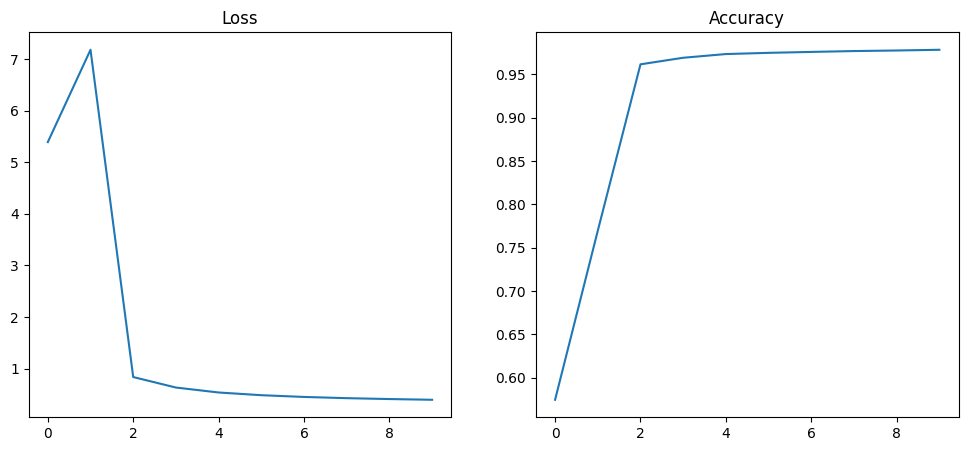

In [12]:
# Train loop

reset_seed(42) # NOTICE: DO NOT CHANGE THIS SEED
# GRADIENT DESCENT HYPER-PARAMETERS
num_epochs = 10
lr = 0.0001

# weight initialization
param_shape = tuple([1, 1])
###########################################
## TODO: the shape for model weight      ##
###########################################

param_shape = tuple([train_features.shape[1], 1])

###########################################
############ End of your code #############
###########################################

w = weight_initialization(param_shape)
w_star = train_gradient_descent(num_epochs, lr, w, train_features, train_targets)

**Task6: Report test result**

In [13]:
# report results on validation / test dataset
test_preds = np.zeros(test_features.shape[0])
###########################################
## TODO: predict on test_dataset         ##
###########################################

for i in range(len(test_preds)):
  z = -1 * test_features[i] @ w_star
  sig = 1 / (1 + np.e ** z)
  if sig >= 0.5:
    test_preds[i] = 1
  else:
    test_preds[i] = -1

###########################################
############ End of your code #############
###########################################

test_acc = np.mean(test_preds == test_targets)
print("GD Test acc: ", test_acc)

GD Test acc:  0.9817464232856438


**Task7: Stochastic Gradient Descent Training**

In this task, you need to implement a function `train_stochastic_gradient_descent` that implements the Stochastic Gradient Descent algorithm, which draws a batch of samples from the train set and updates weights based on this small subset.

Train the model and report the test accuracy.

In [14]:
def train_stochastic_gradient_descent(num_epochs, batch_size, lr, w, train_features, train_targets):
  '''
  This function trains the model w using stochastic gradient desent on the dataset (train_features, train_targets).
  Returns:
  w_star: the optimized model parameter w.
  '''

  losses = []
  accs = []
  N = train_features.shape[0]

  inds = np.arange(train_features.shape[0])
  np.random.shuffle(inds)
  batch_inds = inds[ : batch_size]
  batch_x = train_features[batch_inds]
  batch_y = train_targets[batch_inds]

  # Train loop
  for i in range(num_epochs):
    ###########################################
    ## TODO: Implement SGD                   ##
    ###########################################

    grad = calc_grad(w, batch_x, batch_y)
    w += -1 * lr * grad

    loss = 0
    acc = 0

    for i in range(N):
      x = train_features[i]
      y = train_targets[i]
      loss += np.log(1 + np.e ** (-1 * y * x @ w))
    loss *= (1 / N)

    for i in range(N):
      x = train_features[i]
      y = train_targets[i]
      z = x @ w
      pos = (np.e ** z) / (1 + np.e ** z)
      neg = 1.0 - pos
      if pos > neg:
        if y == 1:
          acc += 1
      else:
        if y == -1:
          acc += 1
    acc = acc / N

    losses.append(loss)
    accs.append(acc)

    ###########################################
    ############ End of your code #############
    ###########################################

  w_star = w

  print("Training done")
  print("Accuracy:", accs)
  visualize_loss_acc(losses, accs)
  return w_star

Training done
Accuracy: [0.8842390857518704, 0.9332401545671298, 0.9402285620323934, 0.9432705746937433, 0.9463948039135082, 0.9473814026144866, 0.9490257337827839, 0.9491901668996136, 0.9518210967688893, 0.9524788292362082]


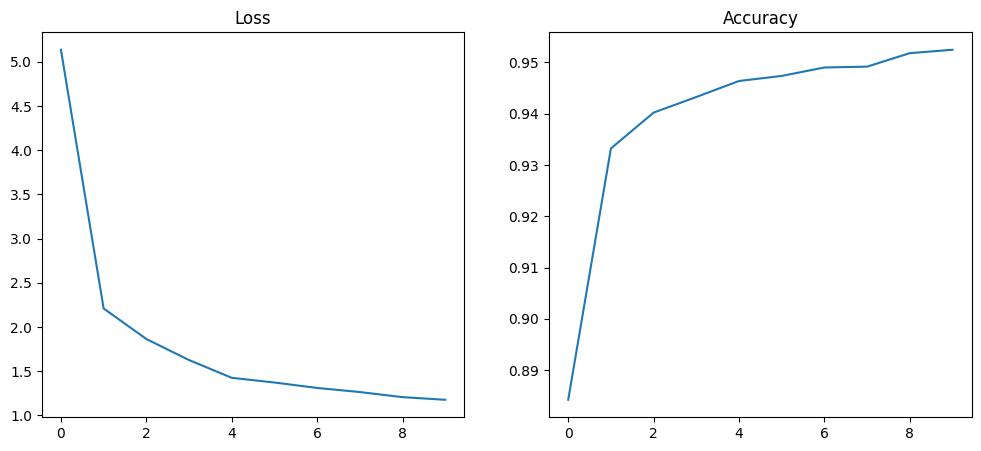

In [15]:
# STOCHASTIC GRADIENT DESCENT HYPER-PARAMETERS
num_epochs = 10
batch_size = 200
lr = 0.01

# weight initialization
param_shape = tuple([1, 1])
###########################################
## TODO: the shape for model weight      ##
###########################################

param_shape = tuple([train_features.shape[1], 1]);

###########################################
############ End of your code #############
###########################################

w = weight_initialization(param_shape)
w_star = train_stochastic_gradient_descent(num_epochs, batch_size, lr, w, train_features, train_targets)

In [16]:
# report results on validation / test dataset
test_preds = np.zeros(test_features.shape[0])
###########################################
## TODO: predict on test_dataset         ##
###########################################

for i in range(len(test_preds)):
  z = -1 * test_features[i] @ w_star
  sig = 1 / (1 + np.e ** z)
  if sig >= 0.5:
    test_preds[i] = 1
  else:
    test_preds[i] = -1

###########################################
############ End of your code #############
###########################################

test_acc = np.mean(test_preds == test_targets)
print("SGD Test acc: ", test_acc)

SGD Test acc:  0.9575727676369018


## Homework (Due on Sat Oct 28, 11:59pm PST)

**Problem 1: GD vs SGD**

Now you have implemented the GD and SGD. In this problem, you need to experiment with different hyper-parameters, e.g., batch size and learning rate.

Plot the training curve of SGD when batch size equals [1, 10, 100], compare them with the training curve of GD. Repeat the process for different learning rates. Discuss your findings.

Results of batch size 1 and learning rate 0.01
Training done
Accuracy: [0.7577900189098085, 0.758694401052372, 0.759269916961276, 0.7594343500781058, 0.7600098659870098, 0.7603387322206693, 0.7605853818959138, 0.7607498150127435, 0.7609964646879882, 0.761078681246403]


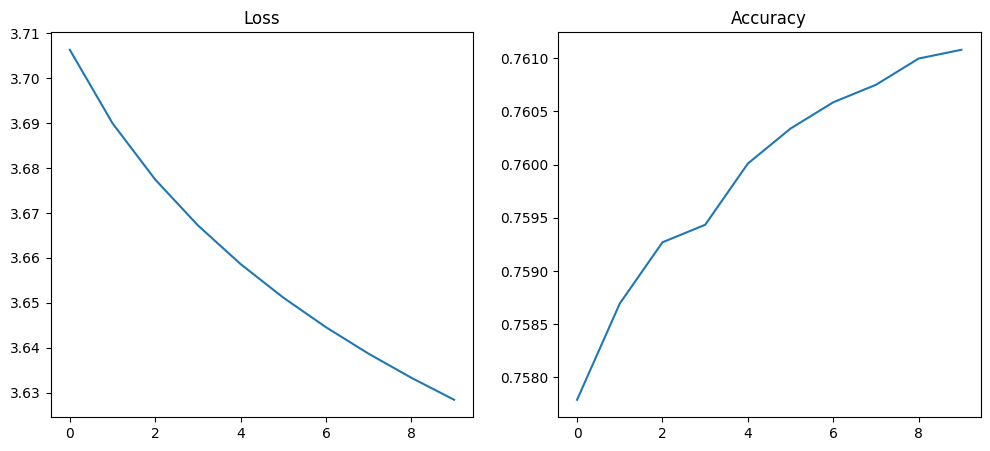

Results of batch size 1 and learning rate 0.005
Training done
Accuracy: [0.6730247471840829, 0.6730247471840829, 0.6730247471840829, 0.6730247471840829, 0.6730247471840829, 0.6730247471840829, 0.6730247471840829, 0.6730247471840829, 0.6730247471840829, 0.6730247471840829]


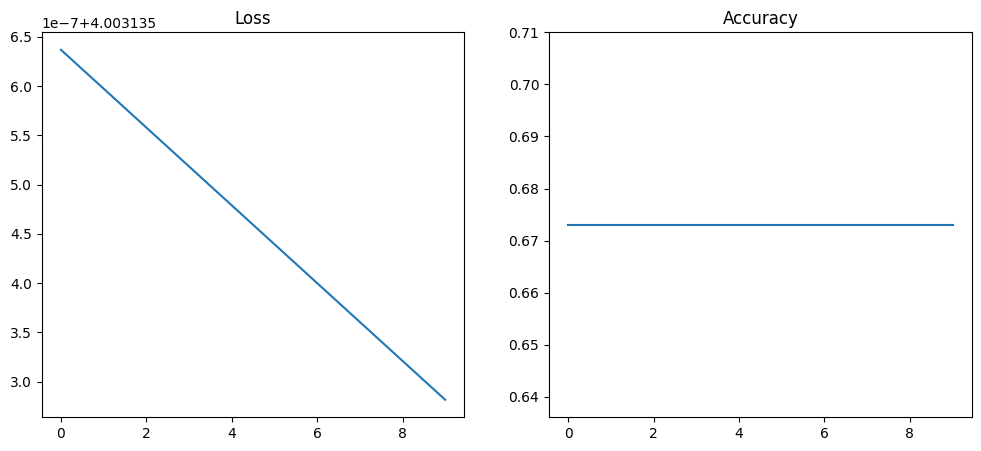

Results of batch size 1 and learning rate 0.001
Training done
Accuracy: [0.3948861300665954, 0.39611937844281836, 0.3977637096111157, 0.39817479240319, 0.4007235057140508, 0.40253226999917785, 0.4049987667516238, 0.40647866480309136, 0.40836964564663325, 0.40968511058127105]


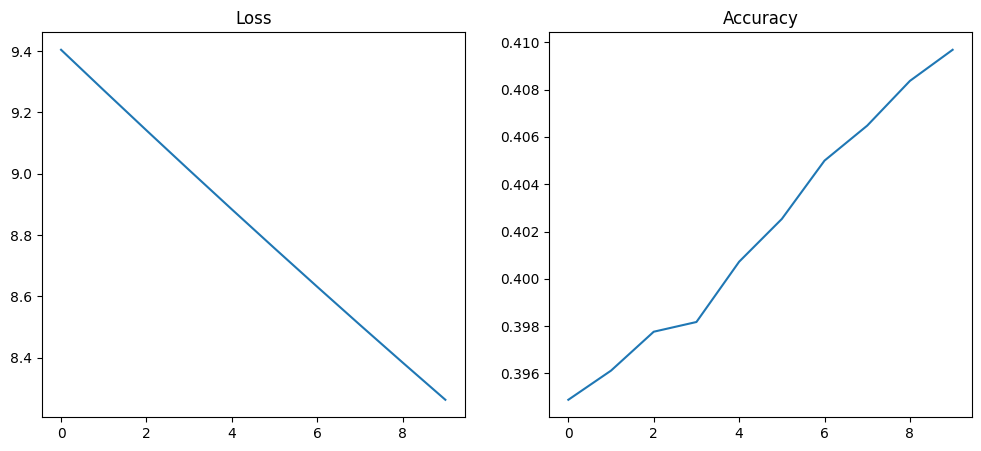

Results of batch size 10 and learning rate 0.01
Training done
Accuracy: [0.7115020965222396, 0.7184905039875031, 0.7281920578804572, 0.740442325084272, 0.7498972293019814, 0.752528159171257, 0.7545835731316287, 0.7558168215078517, 0.7567212036504152, 0.7577900189098085]


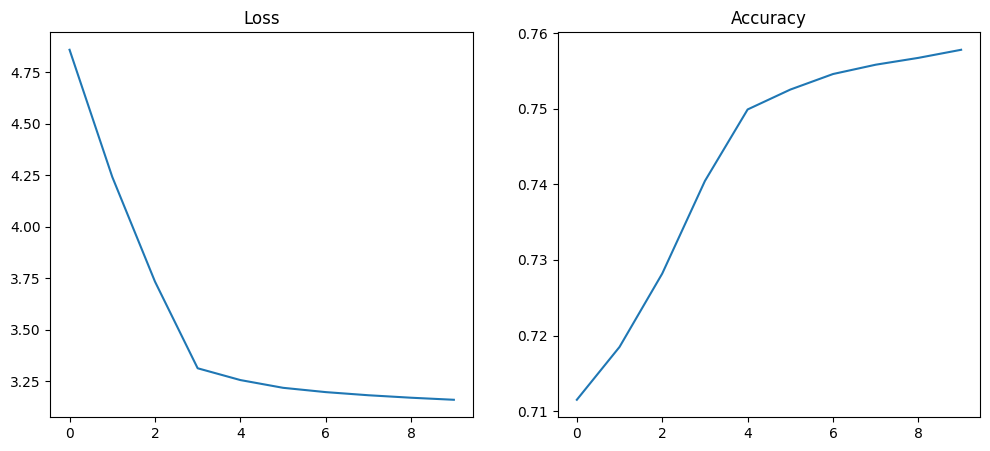

Results of batch size 10 and learning rate 0.005
Training done
Accuracy: [0.7152840582093234, 0.729507522815095, 0.7337827838526679, 0.7350982487873058, 0.7359204143714544, 0.7365781468387733, 0.7369892296308477, 0.7376469620981666, 0.7375647455397517, 0.7378936117734112]


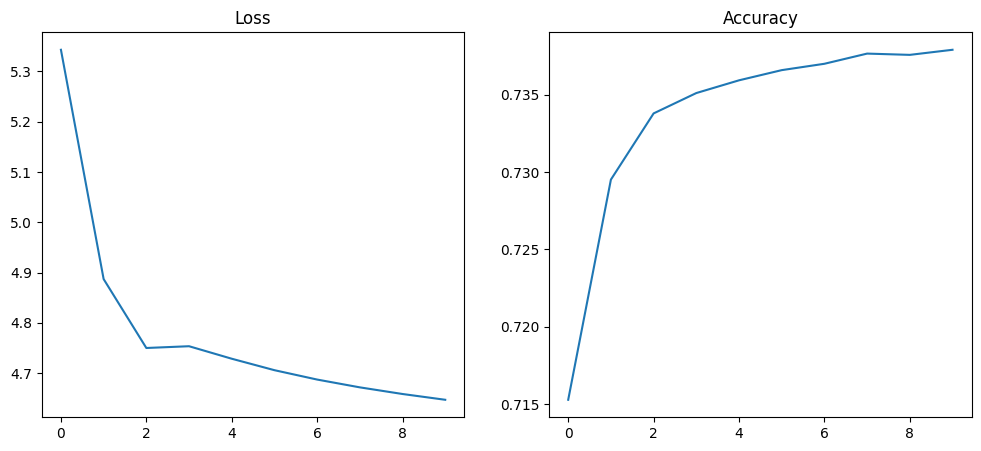

Results of batch size 10 and learning rate 0.001
Training done
Accuracy: [0.7908410753925841, 0.791498807859903, 0.7937186549371044, 0.7962673682479652, 0.7989805146756557, 0.8012825783112719, 0.8037490750637178, 0.8057222724656746, 0.806708871166653, 0.8081065526597057]


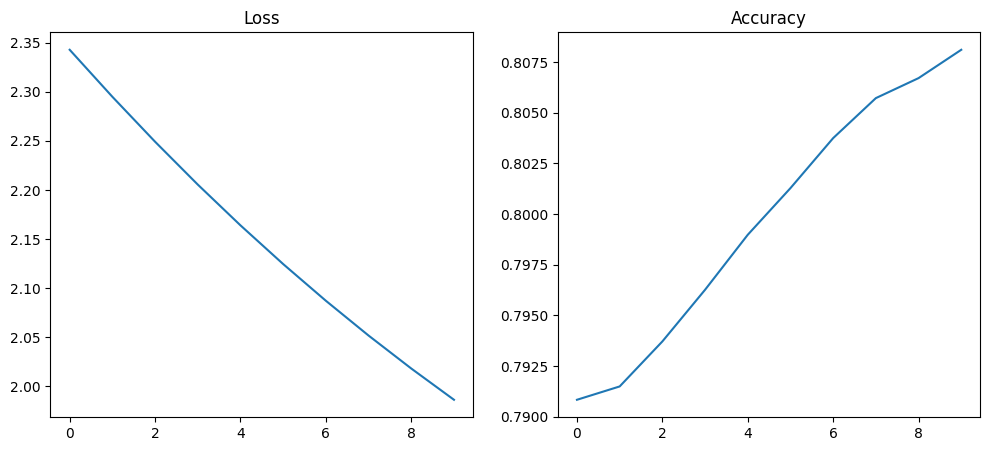

Results of batch size 100 and learning rate 0.01
Training done
Accuracy: [0.8128751130477678, 0.9107950341198717, 0.939241963331415, 0.9401463454739785, 0.9409685110581271, 0.9406396448244676, 0.9423661925511798, 0.9423661925511798, 0.9423661925511798, 0.9426950587848393]


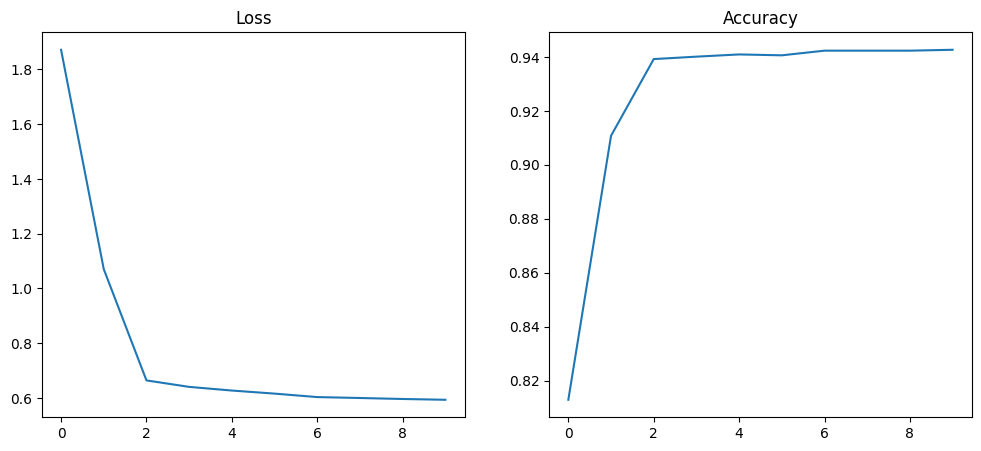

Results of batch size 100 and learning rate 0.005
Training done
Accuracy: [0.8004604127271232, 0.8665625256926746, 0.8807859902984461, 0.8867055825043164, 0.8922140919181123, 0.8965715695141001, 0.9033133273041191, 0.9086574036010853, 0.9147414289237853, 0.9192633396366028]


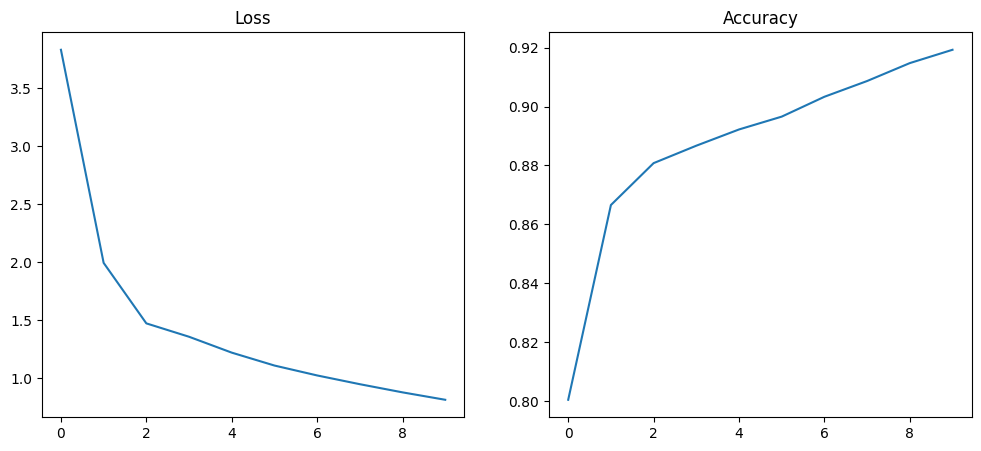

Results of batch size 100 and learning rate 0.001
Training done
Accuracy: [0.8152593932417989, 0.829729507522815, 0.8441996218038313, 0.8571898380333799, 0.8686179396530461, 0.8782372769875852, 0.8862122831538272, 0.8928718243854312, 0.8973115185398339, 0.9001068815259393]


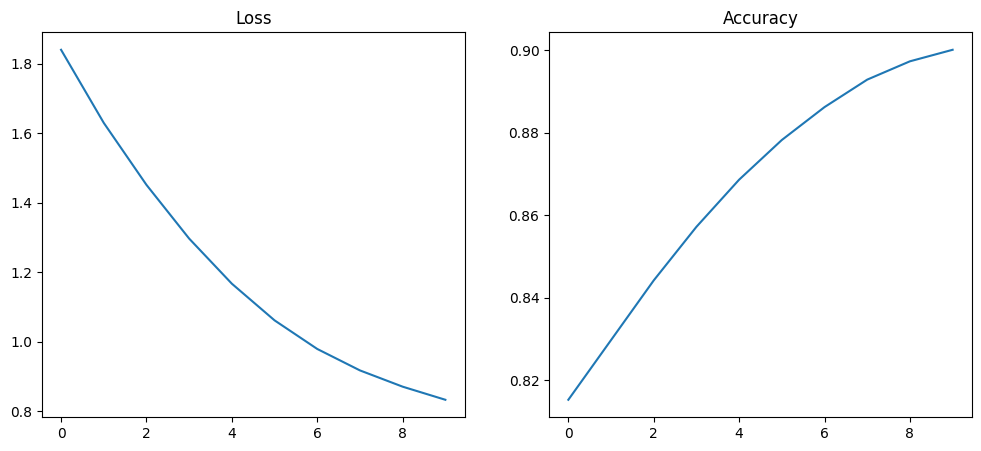

In [20]:
# Problem 1 Code
reset_seed(42)

num_epochs = 10
batch_sizes = [1, 10, 100]
learning_rates = [1e-2, 5e-3, 1e-3]
param_shape = tuple([train_features.shape[1], 1])

for batch_size in batch_sizes:
  for learning_rate in learning_rates:
    print(f"Results of batch size {batch_size} and learning rate {learning_rate}")
    w = weight_initialization(param_shape)
    w_star = train_stochastic_gradient_descent(num_epochs, batch_size, learning_rate, w, train_features, train_targets)



**Problem 1 Report:**

Batch size of 1: For a batch size of 1, the accuracy was lowest (0.76, 0.67, 0.40).

Batch size of 10: For a batch size of 10, the accuracy was slightly better (0.75, 0.73, 0.80).

Batch size of 100: For a batch size of 100, the accuracy was profoundly better (0.94, 0.91, 0.90).

Generally, having a large batch size increased accuracy. This is reasonable since we compute the gradient based on more examples, so our step direction becomes more accurate as we have more examples. In the extreme case where batch size is 1, its hard for a single training example to be representative of the entire training dataset, so the difference between the gradient from the entire train set and the gradient from that single example is probably very high.

Generally, having a lower learning rate decreased accuracy (given that epochs is capped at 10). Since we are sampling only a few examples in SGD, the magnitude of our step size is naturally smaller since we add fewer things to our gradient. Combining this with a low learning rate means our step sizes are extra small, meaning it will take longer to reach minima, which is why we see worse perfomance given a fixed number of epochs.

**Problem 2: Handcrafted feature for 2-class classification.**

In the above implementation, we directly use the raw pixel value as features, i.e., the grayscale value of the original image. However, the pixel values might not be the optimal features for this specific task. In this problem, you need to manually design **two features** that you think would benefit the classification task and use them to train a new model. In other words, your new features should only contain 2 scalars.

You need to
1. Explain how you construct the two features.
2. Report the final test accuracy of your model.
3. Discuss the reason why you think your manually designed features are good \(>95\% accuracy) or bad \(<95\% accuracy\).

In [21]:
# Feature extraction for Problem 2
reset_seed(42)

# custom feature extractor
# normalize each feature by the # of pixels to avoid overflow
def extract_features(raw_features):
  non_black_cnt = 0
  total_col_gap = 0
  total_pixels = raw_features.shape[0] * raw_features.shape[1]

  # feature 1: # of "non-black" pixels
  for pixel in np.nditer(raw_features):
    # threshold for being considered a "non-black" cell
    if pixel > -0.30:
      non_black_cnt += 1

  # feature 2: amount of column gap between "white" pixels
  for col in range(raw_features.shape[1]):
    prev = None
    for row in range(raw_features.shape[0]):
      if raw_features[row, col] < 0.5:
        continue
      if prev != None:
        total_col_gap += (row - prev + 1)
      prev = row

  res = np.array([non_black_cnt, total_col_gap])
  res = res / total_pixels
  return res


pos_class = 1
neg_class = 5
train_features_raw, train_targets = create_2class_subset(train_data, pos_class, neg_class)
test_features_raw, test_targets = create_2class_subset(test_data, pos_class, neg_class)

train_features = np.zeros((train_features_raw.shape[0], 2))
for i in range(train_features.shape[0]):
  train_features[i] = extract_features(train_features_raw[i])

test_features = np.zeros((test_features_raw.shape[0], 2))
for i in range(test_features.shape[0]):
  test_features[i] = extract_features(test_features_raw[i])

train_features, train_targets = random_shuffle(train_features, train_targets)

print(train_features.shape)
print(train_targets.shape)
print(test_features.shape)
print(test_targets.shape)

(12163, 2)
(12163, 1)
(2027, 2)
(2027,)


[[-1.1582191 ]
 [-4.60946721]]
[[2.5536475 ]
 [0.52195018]]
[[-1.27495368]
 [-7.84291734]]
[[ 3.9491982 ]
 [-0.14968689]]
[[-0.00939733]
 [-8.7106364 ]]
[[ 5.23864974]
 [-0.96709308]]
[[ 1.37945305]
 [-9.31061128]]
[[ 6.53982825]
 [-1.69826017]]
[[  2.67829366]
 [-10.00862185]]
[[ 7.79938715]
 [-2.44888958]]
[[  3.9851545 ]
 [-10.63671175]]
[[ 9.04068802]
 [-3.17212806]]
[[  5.25578258]
 [-11.2705326 ]]
[[10.25376654]
 [-3.88811095]]
[[  6.50918795]
 [-11.87771585]]
[[11.44260468]
 [-4.58876019]]
[[  7.73747163]
 [-12.47180444]]
[[12.60564976]
 [-5.27738117]]
[[  8.94371452]
 [-13.04771926]]
[[13.74347166]
 [-5.95294905]]
[[ 10.12680102]
 [-13.60754041]]
[[14.85591593]
 [-6.61600587]]
[[ 11.28716263]
 [-14.15077603]]
[[15.94309652]
 [-7.26658219]]
[[ 12.424739  ]
 [-14.67780452]]
[[17.00507336]
 [-7.90487675]]
[[ 13.53964921]
 [-15.18874342]]
[[18.04194774]
 [-8.53105126]]
[[ 14.6319879 ]
 [-15.68379014]]
[[19.05383575]
 [-9.14528605]]
[[ 15.70188054]
 [-16.16312836]]
[[20.04087385]
 [

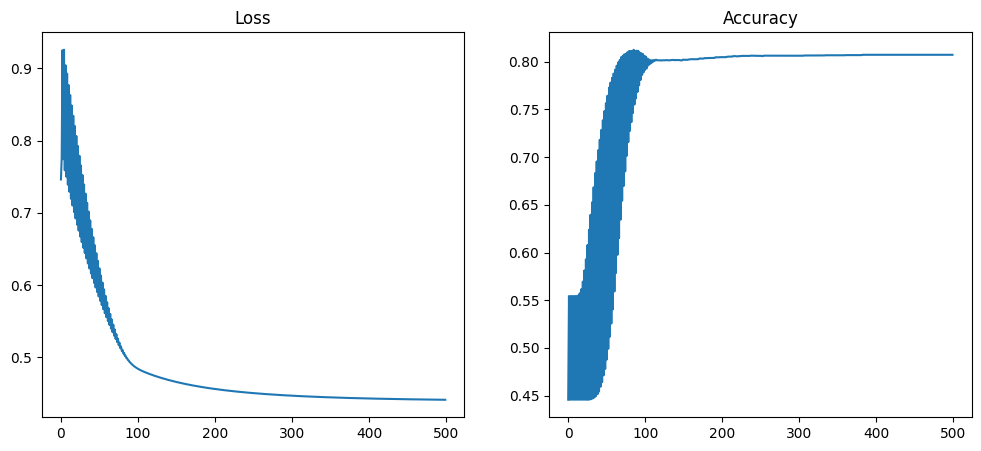

In [22]:
# Training for Problem 2
reset_seed(42)

# GRADIENT DESCENT HYPER-PARAMETERS
# 500, 0.01 is ok
num_epochs = 500
lr = 0.01

# get weights with gd
param_shape = tuple([train_features.shape[1], 1])
w = weight_initialization(param_shape)
w_star = train_gradient_descent(num_epochs, lr, w, train_features, train_targets)

In [23]:
# Evaluation for Problem 2

# report results on validation / test dataset
test_preds = np.zeros(test_features.shape[0])

for i in range(len(test_preds)):
  z = -1 * test_features[i] @ w_star
  sig = 1 / (1 + np.e ** z)
  if sig >= 0.5:
    test_preds[i] = 1
  else:
    test_preds[i] = -1

test_acc = np.mean(test_preds == test_targets)
print("Test acc: ", test_acc)

Test acc:  0.8194375925012334


**Problem 2 Report:**

1:

My first feature is the count of "non-black" pixels. I'm considering a pixel non black if its original grayscale value is 10/255 or higher, which converts to about -0.3 when standardized. I chose this feature since a 5 should generally be written with more white pixels than a 1.

My second feature is the count of column gap between "white" pixels. I'm considering a pixel white if its original grayscale value is 70/255 or higher, which converts to about 0.5 when standardized. Column gap measure how sparsely white pixels are dispersed in a column. If two pixels (x1, y1) and (x2, y2) are white in the same column (x1 == x2), then the column gap is the # of rows between them (y2 - y1 - 1). I chose this feature because a 5 should generally have more column gap than a 1.

2:

The final test accuracy of my model was about 0.819

3:

My manually designed features are bad (way below 0.95 accuracy). Feature 1 is bad because it's not invariant to transformations (mainly scaling). If a 1 is drawn large, or a 5 is drawn small, then the number of non-black pixels will be a misleading indicator. Feature 2 is bad because the shape of the written 1s and 5s can be poor (differing from the ideal shape of a 1 or 5). I think another factor is being limited to two features; we can't capture that much information, and having more features would also improve accuracy.


**Problem 3: Extend to 10-class classification on MNIST**

Up to now, we only classify 2 classes in MNIST dataset. In this problem, you need to extend the model such that it can classify all 10 digits in the dataset.

To do that, you need to change the sigmoid function in the model into a softmax function, so that the output is a probability distribution over 10 classes. You also need to change the loss function to Cross Entropy loss.

In [27]:
# Feature extraction for Problem 3

def random_shuffle_multiclass(features, targets):
  perm = np.random.permutation(features.shape[0])
  shuffled_features = features[perm]
  shuffled_targets = targets[perm]
  return (shuffled_features, shuffled_targets)

def transform_mnist_multiclass(dataset):

    features = []
    targets = []

    for sample in dataset:
        image, label = sample
        features.append(normalize_image(image))
        one_hot = np.zeros(10)
        one_hot[label] = 1
        targets.append(one_hot)

    features = np.stack(features)
    targets = np.stack(targets)

    return features, targets

train_x, train_y = transform_mnist_multiclass(train_dataset_)
test_x, test_y = transform_mnist_multiclass(test_dataset_)
train_x = raw_feature_func(train_x)
test_x = raw_feature_func(test_x)
train_x, train_y = random_shuffle_multiclass(train_x, train_y)

print(train_x.shape) # the shape should be (60000, 784)
print(train_y.shape) # the shape should be (60000, 10)
print(test_x.shape)
print(test_y.shape)

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


[[ 0.50749639 -0.12748206  0.65847078 ... -1.32456212  0.39098009
   0.62136798]
 [ 0.6196048   1.14059507  0.8937365  ... -0.22151321  0.12680507
   0.57575357]
 [-1.64642786 -0.61293468  0.71038267 ... -0.47589465  0.97605438
   0.53312394]
 ...
 [-0.79447438 -0.46746906 -0.49403712 ...  0.4109652  -0.44535974
   0.65881011]
 [-0.06205121 -1.05199711 -0.37337054 ...  0.35457549  0.17290789
  -1.69609336]
 [-0.34553869 -0.10255631  1.8779352  ... -0.15299343 -0.35112345
  -0.43689583]]
[[ 0.46256133 -0.17241713  0.61353571 ... -1.36949718  0.34604503
   0.57643292]
 [ 0.52427298  1.04526325  0.79840468 ... -0.31684503  0.03147325
   0.48042175]
 [-1.69428022 -0.66078704  0.66253032 ... -0.523747    0.92820202
   0.48527159]
 ...
 [-0.76651778 -0.43951247 -0.46608052 ...  0.43892179 -0.41740315
   0.68676671]
 [-0.13068801 -1.12063391 -0.44200733 ...  0.2859387   0.1042711
  -1.76473016]
 [-0.16795907  0.07502331  2.05551483 ...  0.02458619 -0.17354382
  -0.25931621]]
[[ 0.48832955 -0.

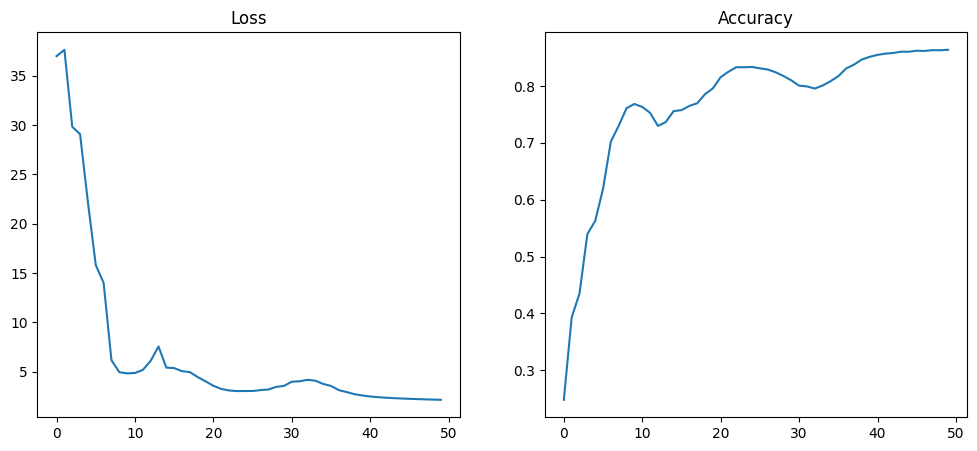

In [25]:
# Training for Problem 3
reset_seed(42)

# w is (10 x 784), features is (60000 x 784), targets is (60000 x 10)
def calc_grad_multiclass(w, features, targets):
    grad = np.zeros([targets.shape[1], features.shape[1]])
    for i in range(features.shape[0]):
        x = features[i]
        y = targets[i]
        label = np.nonzero(y)[0][0]
        denominator = 0
        for j in range(w.shape[0]):
            denominator += (np.e ** (x @ w[j]))
        for j in range(w.shape[0]):
            numerator = np.e ** (x @ w[j])
            g = (numerator / denominator) * x
            if j == label:
                g -= x
            grad[j] += g
    grad = grad / features.shape[0]
    return grad


def train_gradient_descent_multiclass(num_epochs, lr, w, features, targets):
    losses = []
    accs = []
    N = features.shape[0]

    for step in range(num_epochs):
        grad = calc_grad_multiclass(w, features, targets)
        w += -1 * lr * grad
        print(w[:10])

        # compute loss:
        loss, acc = 0, 0
        for i in range(N):
            x = features[i]
            y = targets[i]
            label = np.nonzero(y)[0][0]
            numerator = (np.e ** (x @ w[label]))
            denominator = 0
            for j in range(w.shape[0]):
                denominator += (np.e ** (x @ w[j]))
            loss += -1 * np.log(numerator / denominator)
        loss = loss / N

        # compute acc:
        for i in range(N):
            x = features[i]
            y = targets[i]
            label = np.nonzero(y)[0][0]
            prob = [0] * 10
            denominator = 0
            for j in range(w.shape[0]):
                denominator += (np.e ** (x @ w[j]))
            for j in range(w.shape[0]):
                numerator = np.e ** (x @ w[j])
                prob[j] = (numerator / denominator)
            pred = prob.index(max(prob))
            if pred == label:
                acc += 1
        acc = acc / N

        losses.append(loss)
        accs.append(acc)

    w_star = w
    print("Training done")
    print(losses)
    print(accs)
    visualize_loss_acc(losses, accs)
    return w_star


# 85 has highest training, try 50 and 75 too
num_epochs = 50
lr = 2

param_shape = tuple([train_y.shape[1], train_x.shape[1]])
w = weight_initialization(param_shape)
w_star = train_gradient_descent_multiclass(num_epochs, lr, w, train_x, train_y)

In [1]:
# Evaluation for Problem 3

N = test_x.shape[0]
acc = 0
for i in range(N):
    x = test_x[i]
    y = test_y[i]
    label = np.nonzero(y)[0][0]
    prob = [0] * 10
    denominator = 0
    for j in range(w.shape[0]):
        denominator += (np.e ** (x @ w[j]))
    for j in range(w.shape[0]):
        numerator = np.e ** (x @ w[j])
        prob[j] = (numerator / denominator)
    pred = prob.index(max(prob))
    if pred == label:
        acc += 1
acc = acc / N
print("accuracy:", acc)

NameError: ignored

**Problem 3 Report:**

Accuracy on test set: 0.8755

The accuracy is lower than in the binary classification case, but this is expected since there are more classes to have potential misclassifcations.